# Self-Attention

ps：

pip install d2l

pip install matplotlib==3.0.0

给定⼀个由词元组成的输⼊序列$x_1,...,x_n$，其中任意$x_i\in \mathbb R_d (i\leq i\leq n)$。该序列的⾃注意⼒输出为⼀个⻓
度相同的序列$y_1,...y_n$，其中：

$$
y_i = f(x_i,(x_1,x_1),...,(x_n,x_n)) \in \mathbb R^d
$$

In [1]:
import os
import math
import re
import collections
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from model.RNN import *

## Self Attention Process

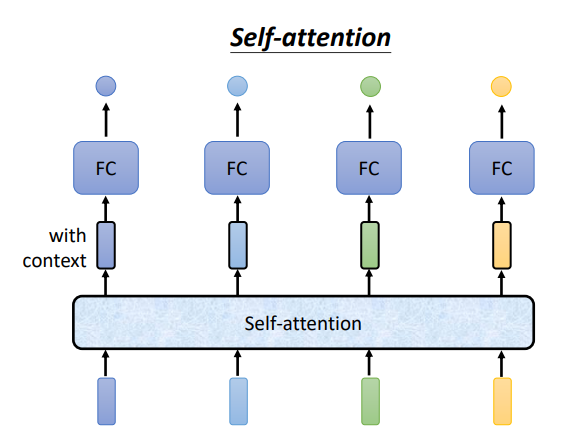

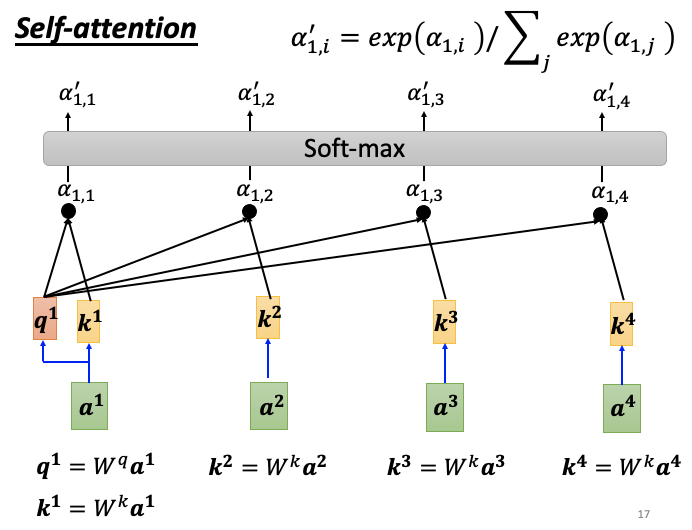

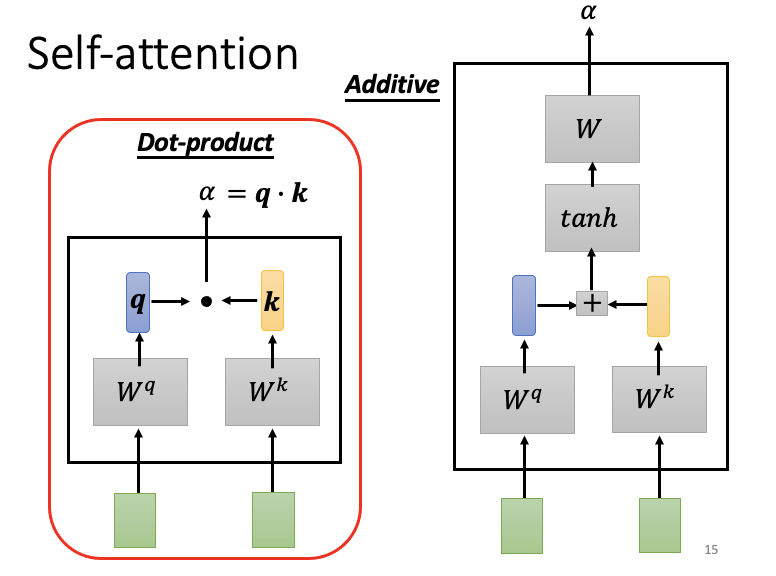

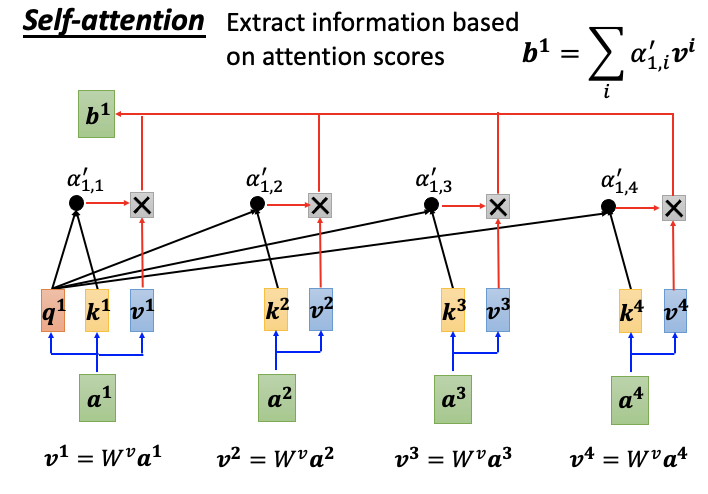

## Multi-head Self-attention

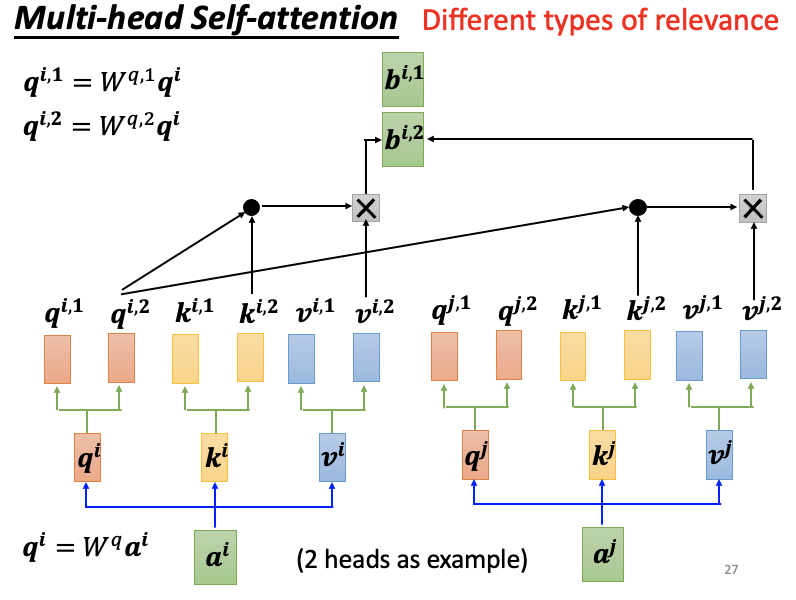

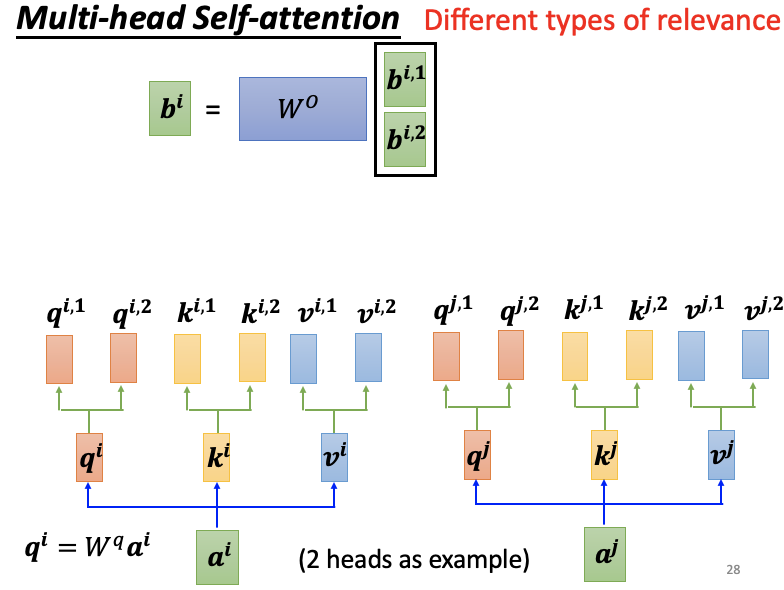

给定查询$\pmb q \in \mathbb R^{d_q}$ 、键$\pmb k \in \mathbb R^{d_k}$ 和
值$\pmb v \in \mathbb R^{v_q}$ ，每个注意力头$\pmb h_i(i = 1, . . . , h)$的计算方法为:
$$
\pmb h_i = f(\pmb W_i^q\pmb q,\pmb W_i^k\pmb k,\pmb W_i^v\pmb v) \in \mathbb R^{p_v}
$$

随后，将每个头的注意力堆叠在一起，经过一个没有bias的线性变化得到汇聚注意了力。

$$
\pmb W_o \left[ \begin{matrix}\pmb h_1\\
.\\
.\\
\pmb h_h\\
\end{matrix}\right]\in \mathbb R^{p_v}
$$

In [2]:
def transpose_qkv(X, num_heads): 
  """为了多注意力头的并行计算而变换形状"""
  # 输入X的形状:(batch_size，查询或者“键-值”对的个数，num_hiddens) 
  # 输出X的形状:(batch_size，查询或者“键-值”对的个数，num_heads， 
  # num_hiddens/num_heads)
  X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

  # 输出X的形状:(batch_size，num_heads，查询或者“键-值”对的个数, 
  # num_hiddens/num_heads)
  X = X.permute(0, 2, 1, 3)

  # 最终输出的形状:(batch_size*num_heads,查询或者“键-值”对的个数, 
  # num_hiddens/num_heads)
  return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads): 
  """逆转transpose_qkv函数的操作"""
  X = X.reshape(-1, num_heads, X.shape[1], X.shape[2]) 
  X = X.permute(0, 2, 1, 3)
  return X.reshape(X.shape[0], X.shape[1], -1)

In [3]:
class MultiHeadAttention(nn.Module):
  """多头注意力"""
  def __init__(self, key_size, query_size, value_size, num_hiddens, 
               num_heads, dropout, bias=False, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

  def forward(self, queries, keys, values, valid_lens): # queries，keys，values的形状:
    # (batch_size，查询或者“键-值”对的个数，num_hiddens) # valid_lens 的形状:
    # (batch_size，)或(batch_size，查询的个数)
    # 经过变换后，输出的queries，keys，values 的形状:
    # (batch_size*num_heads，查询或者“键-值”对的个数，
    # num_hiddens/num_heads)
    queries = transpose_qkv(self.W_q(queries), self.num_heads) 
    keys = transpose_qkv(self.W_k(keys), self.num_heads) 
    values = transpose_qkv(self.W_v(values), self.num_heads)
    if valid_lens is not None:
      # 在轴0，将第一项(标量或者矢量)复制num_heads次， 
      # 然后如此复制第二项，然后诸如此类。
      valid_lens = torch.repeat_interleave(
                    valid_lens, repeats=self.num_heads, dim=0)

    # output的形状:(batch_size*num_heads，查询的个数，
    # num_hiddens/num_heads)
    output = self.attention(queries, keys, values, valid_lens)

    # output_concat的形状:(batch_size，查询的个数，num_hiddens) 
    output_concat = transpose_output(output, self.num_heads) 
    return self.W_o(output_concat)

In [4]:
num_hiddens, num_heads = 20, 4
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=20, out_features=20, bias=False)
  (W_k): Linear(in_features=20, out_features=20, bias=False)
  (W_v): Linear(in_features=20, out_features=20, bias=False)
  (W_o): Linear(in_features=20, out_features=20, bias=False)
)

In [5]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))

In [6]:
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 20])

## Position Encode

Self-attention 在处理序列时，是没有位置信息的，如果将顺序打乱，Self-attention的输出结果是一样的，为了加入位置信息，就有了不同的位置编码。

在处理词元序列时，循环神经⽹络是逐个的重复地处理词元的，⽽⾃注意⼒则因为并⾏计算⽽放弃了顺序操
作。为了使⽤序列的顺序信息，我们通过在输⼊表⽰中添加位置编码（positional encoding）来注⼊绝对的
或相对的位置信息。位置编码可以通过学习得到也可以直接固定得到。接下来，我们描述的是基于正弦函数
和余弦函数的固定位置编码。

假设输⼊表⽰$\pmb X \in \mathbb R ^{n*d}$包含⼀个序列中n个词元的d维嵌⼊表⽰。位置编码使⽤相同形状的位置嵌⼊矩阵$\pmb P \in \mathbb R ^{n*d}$ 输出 $\pmb {X+P}$,矩阵第i⾏、第2j列和2j + 1列上的元素为：
$$
p_{i,2j} = sin(\frac{i}{10000^{2j/d}})\\
p_{i,2j+1} = cos(\frac{i}{10000^{2j/d}})
$$

In [7]:
class PositionalEncoding(nn.Module): 
  """位置编码"""
  def __init__(self, num_hiddens, dropout, max_len=1000): 
    super(PositionalEncoding, self).__init__() 
    self.dropout = nn.Dropout(dropout)
    # 创建一个足够⻓的P
    self.P = torch.zeros((1, max_len, num_hiddens))
    X = torch.arange(max_len, dtype=torch.float32).reshape(
        -1, 1) / torch.pow(10000, torch.arange(
        0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X)
    self.P[:, :, 1::2] = torch.cos(X)
  
  def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device) 
    return self.dropout(X)

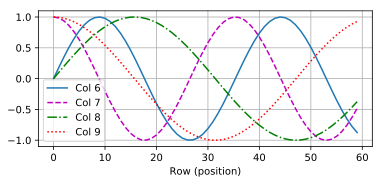

In [8]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])